# Ptychography Reconstruction

This notebook demonstrates a simulated ptychographic reconstruction using tike.

In [1]:
%env TIKE_BACKEND=cupy

env: TIKE_BACKEND=cupy


In [2]:
import importlib
import logging

import matplotlib.pyplot as plt
import numpy as np

import tike
import tike.ptycho
import tike.view

In [3]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.8.2.dev72+g7286faa.d20200504
numpy is version 1.18.1


## Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

In [4]:
amplitude = plt.imread("../../../tests/data/Cryptomeria_japonica-0128.png")
phase = plt.imread("../../../tests/data/Bombus_terrestris-0128.png") * np.pi
np.min(phase), np.max(phase)

(0.036959916, 3.1292727)

In [5]:
ntheta = 1  # number angular views
original = np.tile(amplitude * np.exp(1j * phase), (ntheta, 1, 1)).astype('complex64')
original.shape

(1, 128, 128)

(-0.9999241+0.012319642j) (0.99514693+0.09840028j)


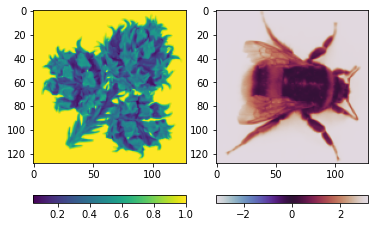

In [6]:
plt.figure()
tike.view.plot_phase(original[0])
plt.show()

### Define the probe

Note that the shape of the probe includes many dimensions. These dimensions are for providing unique probes in various situations such as for each projection, for each frame, for each fly scan position, for each incoherent mode.

In [7]:
from tike.ptycho.probe import add_modes_random_phase
np.random.seed(0)
pw = 15 # probe width
nmode = 3
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * 0) * 10
probe = np.tile(probe, (ntheta, 1, 1)).astype('complex64')[:, np.newaxis, np.newaxis, np.newaxis]
probe = add_modes_random_phase(probe, nmode)
probe.shape

(1, 1, 1, 3, 15, 15)

/home/dching/Documents/tike/src/tike/view.py:94: UserWarning: This phase plot will be incorrect because the phase of a zero-amplitude complex number is undefined. Adding a small constant to the amplitude may help.
  warnings.warn(


0j (10+0j)


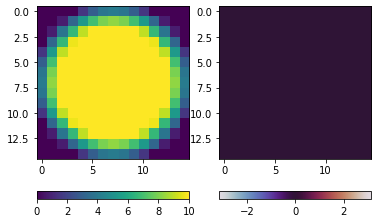

0j (10+0j)


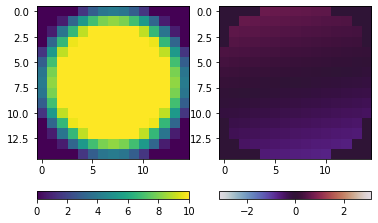

0j (10+0j)


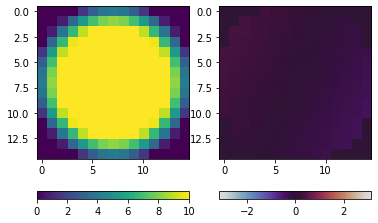

In [8]:
for m in range(probe.shape[-3]):
    plt.figure()
    tike.view.plot_phase(probe[0, 0, 0, m])
    plt.show()

### Define the trajectory

Each projection may have a different trajectory, but the number of scan positions must be the same. The probe positions that overlap the edge of psi are skipped.

In [9]:
buffer = 5
v, h = np.meshgrid(
    np.linspace(buffer, amplitude.shape[0]-pw-buffer, 21, endpoint=True),
    np.linspace(buffer, amplitude.shape[0]-pw-buffer, 21, endpoint=True),
    indexing='ij'
)

In [10]:
scan = np.tile(np.stack((np.ravel(v), np.ravel(h)), axis=1), (ntheta, 1, 1)).astype('float32')
scan.shape

(1, 441, 2)

In [11]:
np.random.seed(0)
true_scan = scan + (np.random.rand(*scan.shape) - 0.5) * 4

## Simulate data acquisition

In [12]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(detector_shape=pw*2,
                            probe=probe, scan=true_scan,
                            psi=original)
np.random.seed(0)
data = np.random.poisson(data)
data.shape

(1, 441, 30, 30)

<ipython-input-13-c9624854b263>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.fft.fftshift(np.log(data[0, 11])))


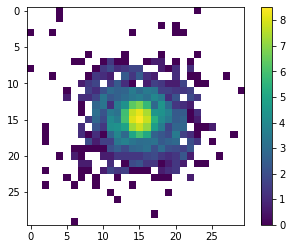

(0, 6978)

In [13]:
plt.figure()
plt.imshow(np.fft.fftshift(np.log(data[0, 11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

## Reconstruct

Now we need to try and reconstruct psi.

In [14]:
# Provide initial guesses for parameters that are updated
result = {
    'psi': np.zeros(original.shape, dtype='complex64') + 1e-32,
    'probe': np.ones_like(probe),
    'scan': scan,
    'λ': 0,  # parameter for ADMM
    'μ': 0,  # parameter for ADMM
}

INFO:tike.ptycho.ptycho:combined for 441 - 30 by 30 frames for 32 iterations.
INFO:tike.ptycho.solvers.combined:    object cost is +1.56290e+06
INFO:tike.ptycho.solvers.combined:     probe cost is +1.02331e+06
INFO:tike.ptycho.position:  position cost is +9.89625e+05
INFO:tike.ptycho.solvers.combined:    object cost is +4.56003e+05
INFO:tike.ptycho.solvers.combined:     probe cost is +3.73628e+05
INFO:tike.ptycho.position:  position cost is +3.63031e+05
INFO:tike.ptycho.solvers.combined:    object cost is +2.42947e+05
INFO:tike.ptycho.solvers.combined:     probe cost is +2.25708e+05
INFO:tike.ptycho.position:  position cost is +2.19836e+05
INFO:tike.ptycho.solvers.combined:    object cost is +1.73591e+05
INFO:tike.ptycho.solvers.combined:     probe cost is +1.69430e+05
INFO:tike.ptycho.position:  position cost is +1.65472e+05
INFO:tike.ptycho.solvers.combined:    object cost is +1.48590e+05
INFO:tike.ptycho.solvers.combined:     probe cost is +1.46750e+05
INFO:tike.ptycho.position:  po

(-8.303703-3.265508j) (15.970119+4.3362246j)
(-0.06815223+0.041217722j) (1.0685748-0.12255487j)
(-0.05043617-0.005356382j) (1.2771003+0.044113617j)
(-0.014749419+0.016089208j) (1.4083067-0.008370091j)


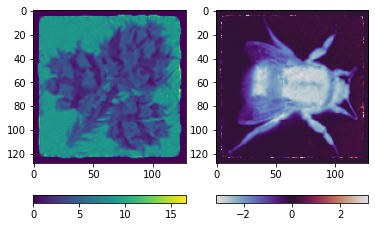

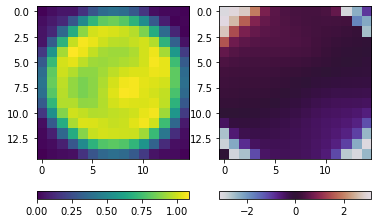

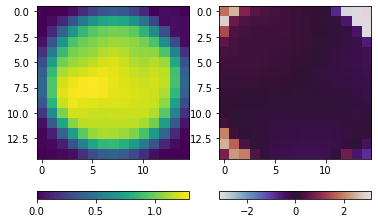

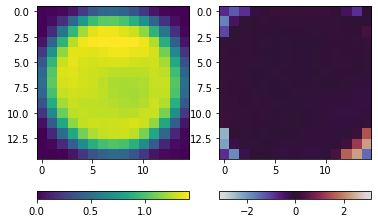

In [15]:
logging.basicConfig(level=logging.INFO)

for i in range(1):
    result = tike.ptycho.reconstruct(
        data=data,
        **result,
        algorithm='combined',
        num_iter=32,
        recover_probe=True,
        recover_positions=True,
    )
    plt.figure()
    tike.view.plot_phase(result['psi'][ntheta // 2], amin=0)
    for m in range(probe.shape[-3]):
        plt.figure()
        tike.view.plot_phase(result['probe'][0, 0, 0, m], amin=0)
    plt.show()